[Reference](https://medium.com/data-bistrot/customer-churn-a-classification-problem-to-solve-with-python-31f572652246)

In [1]:
import numpy as np  # Linear algebra
import pandas as pd  # Data processing
from numpy import log
from datetime import date
import seaborn as sns  # Data visualization
import matplotlib.ticker as mtick  # Formatting axes in plots
import matplotlib.pyplot as plt
import plotly.graph_objects as go  # Interactive plots

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix, precision_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE  # Synthetic Minority Over-sampling Technique

from scipy.stats import randint as sp_randint, uniform as sp_uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style='white')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [20]:
def bar_plot(df,ax, column_name= None,xlabel= None, ylabel= None, title= None,colors = ['#042370','#D63F1D'], reorderlist = None):
    """
    Python function to plot a specific column of dataframe
    df: dataframe
    colum_name: column to plot
    xlabel:  y axis label
    ylabel:  y axis label
    colors: colors of the bars
    """
    #colors
    colors = colors

    #percentage of total
    df = df[column_name].value_counts()*100.0 /len(df)
     #reorder
    if reorderlist is not None:
        df = df.reindex(reorderlist)

    #group by column and count
    df.plot(ax= ax,kind='bar',
             stacked = True,
             rot = 0,
             color = colors,
             #figsize = (15,8)
           )
    #format axis and labels
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_visible(False)
    ax.set_ylabel(ylabel,size = 14)
    ax.set_xlabel(xlabel,size = 14)
    ax.set_title(title, size = 14)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_x()+.10, i.get_height()-8.0, str(round((i.get_height()/total), 1))+'%',\
                fontsize=16,
                color='white',
                weight = 'bold',
                )

    return

###############################################################


def bar_plot_tot(df, ax, column_name= None,xlabel= None, ylabel= None, title= None,colors = ['#042370','#D63F1D'],reorderlist = None):
    """
    Python function to plot a specific column of dataframe
    df: dataframe
    colum_name: column to plot
    xlabel:  y axis label
    ylabel:  y axis label
    colors: colors of the bars
    """
    #colors
    colors = colors
    #totald
    df = df[column_name].value_counts()
     #reorder
    if reorderlist is not None:
        df = df.reindex(reorderlist)

    #group by column and count
    df.plot.barh(ax= ax,
                 stacked = True,
                 rot = 0,
                 color = colors,
                # figsize = (15,8)
                )
    #format axis and labels
   # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel(ylabel,size = 14)
    ax.set_xlabel(xlabel,size = 14)
    ax.set_title(title, size = 14)

    ax.xaxis.set_visible(False)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)

    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())
    for i, v in enumerate(totals):
        ax.text(v/2-(v/3), i, str(int(v)), color='white', fontweight='bold', fontsize=16, ha='left', va='center')


    return


########################################

def bar_stacked_plot(df, ax, label=None, feature=None, title=None, colors=['#042370', '#D63F1D'], reorderlist=None):
    """
    Python function to plot a stacked bar plot based on feature/label aggregation count
    df: dataframe
    label : label of dataframe
    feature: feature of dataframe
    title:  plot title
    colors: colors of the bars
    reorderlist: specify order if ordinal
    """
    # Group by label and feature and count the feature
    df = df.groupby([feature, label]).size().unstack()

    # Reorder if needed
    if reorderlist is not None:
        df = df.reindex(reorderlist)

    # Plot the stacked bar chart
    (df.T * 100.0 / df.T.sum()).T.plot(
        kind='bar',
        ax=ax,
        width=0.6,
        stacked=True,
        rot=0,
        color=colors
    )

    # Set font
    csfont = {'fontname': 'sans-serif'}

    # Set axis parameters, title, and labels
    ax.yaxis.set_visible(False)
    ax.set_ylabel('% ' + feature, size=14, **csfont)
    ax.set_xlabel('')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 14}, title=label)
    ax.set_title(title, size=14, **csfont)

    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add data labels at the center of each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x = p.get_x()
        y = p.get_y()

        # Center the label in the middle of the bar
        ax.annotate(
            '{:.0f}%'.format(height),
            (x + width / 2, y + height / 2),
            ha='center', va='center',
            color='white',
            weight='bold',
            size=14
        )

    return


########################################

def dist_plot_kde(df, ax, label, feature ,xlabel= None,  title= None):
    """
    Python function to plot the distribution of a feature for positive or negative label values
    df: dataframe
    ax: plot definition
    label: label
    feature: feature
    title: title of the plot
    xlabel:  x axis label

    """
    #positive label
    ax = sns.kdeplot(cust_df[feature].loc[(cust_df[label] == 1)],
                     color="Red", shade = True)
    #negative label
    ax = sns.kdeplot(cust_df[feature].loc[(cust_df[label] == 0)],
                     ax =ax, color="Blue", shade= True, alpha= 0.2)

    #legend and other plot labels
    ax.legend([label,"Not " + label ],loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    return


########################################

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
    return scores

########################################

# define models to test
def get_models():
    models, names = list(), list()
    # CART
    models.append(DecisionTreeClassifier())
    names.append('CART')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    # Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    # GBM
    models.append(GradientBoostingClassifier(n_estimators=100))
    names.append('GBM')
    #LightGBM
    models.append(LGBMClassifier())
    names.append('LightGBM')
    # LR
    # models.append(LogisticRegression())
    # names.append('LR')
    return models, names

# Load the Data

In [2]:
# Load the dataset from CSV file
cust_df = pd.read_csv('https://raw.githubusercontent.com/nicoardimas/Credit_Card_Customer_Churn/refs/heads/main/BankChurners.csv')

# Drop the last two columns and the customer number column, which are not useful for the analysis
cust_df = cust_df.iloc[:, :-2]
cust_df.drop(columns=["CLIENTNUM"], inplace=True)

# Display the first few rows of the dataset
cust_df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28


# Data Munging Steps

In [3]:
# Check for unique values in the target column 'Attrition_Flag'
cust_df['Attrition_Flag'].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [4]:
# Define churn as 1 (Yes) and 0 (No)
cust_df["Churn"] = np.where(cust_df["Attrition_Flag"] == "Attrited Customer", 1, 0)

# Remove the original 'Attrition_Flag' column
cust_df.drop(columns=["Attrition_Flag"], inplace=True)

In [5]:
# Check for null values in the dataset
cust_df.isnull().sum()

,0
Customer_Age,0
Gender,0
Dependent_count,0
Education_Level,0
Marital_Status,0
Income_Category,0
Card_Category,0
Months_on_book,0
Total_Relationship_Count,0
Months_Inactive_12_mon,0


In [7]:
# Check unique values in 'Income_Category'
cust_df['Income_Category'].unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [8]:
# Replace 'Unknown' incomes with the mode of the 'Income_Category'
cust_df['Income_Category'].replace('Unknown', cust_df['Income_Category'].mode()[0], inplace=True)

# EDA (Exploratory Data Analysis)

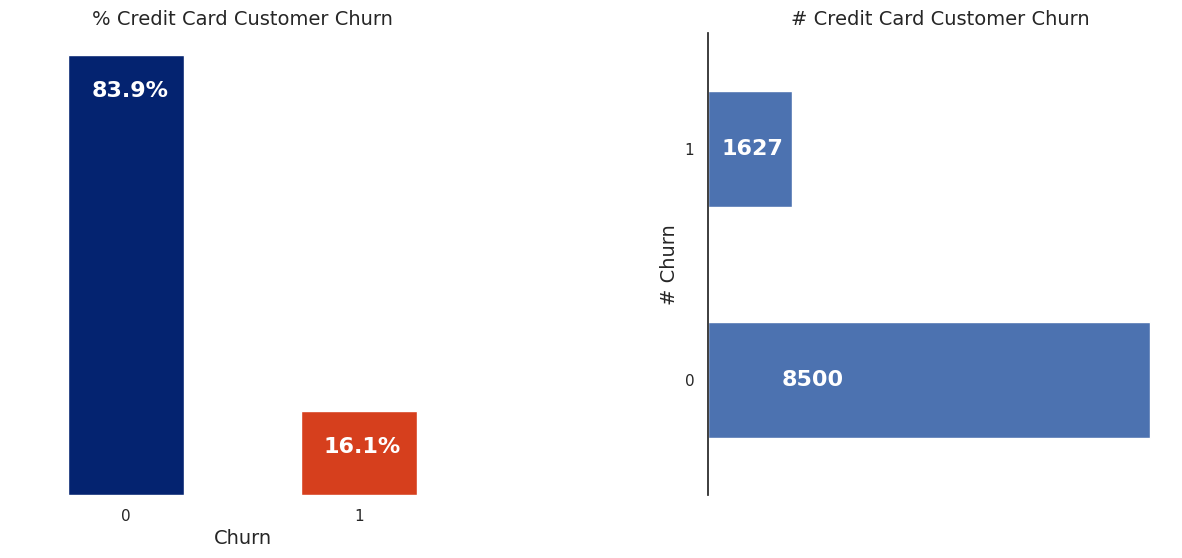

In [21]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(15)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_plot(cust_df,ax1,column_name= "Churn",xlabel= "Churn", ylabel= "% Churn Rate", title= "% Credit Card Customer Churn")

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= "Churn",xlabel= "Churn", ylabel= "# Churn", title= "# Credit Card Customer Churn",colors = 'b')

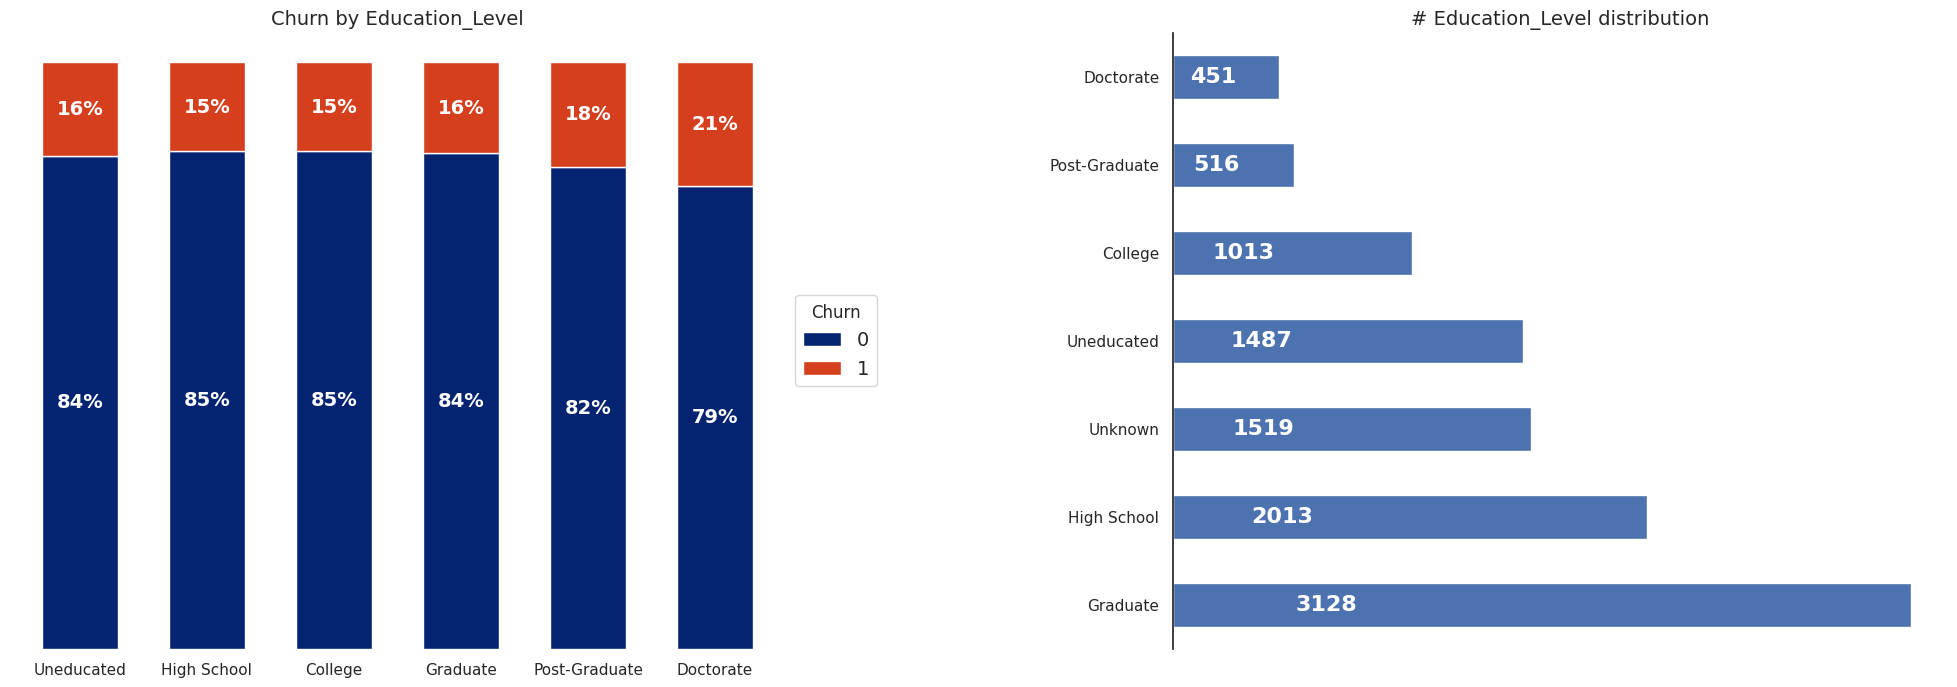

In [22]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(25)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

#reorder the categories
reorderlist =['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Education_Level', title= 'Churn by Education_Level', reorderlist = reorderlist)

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Education_Level',  title= "# Education_Level distribution",colors=  ['b'] )

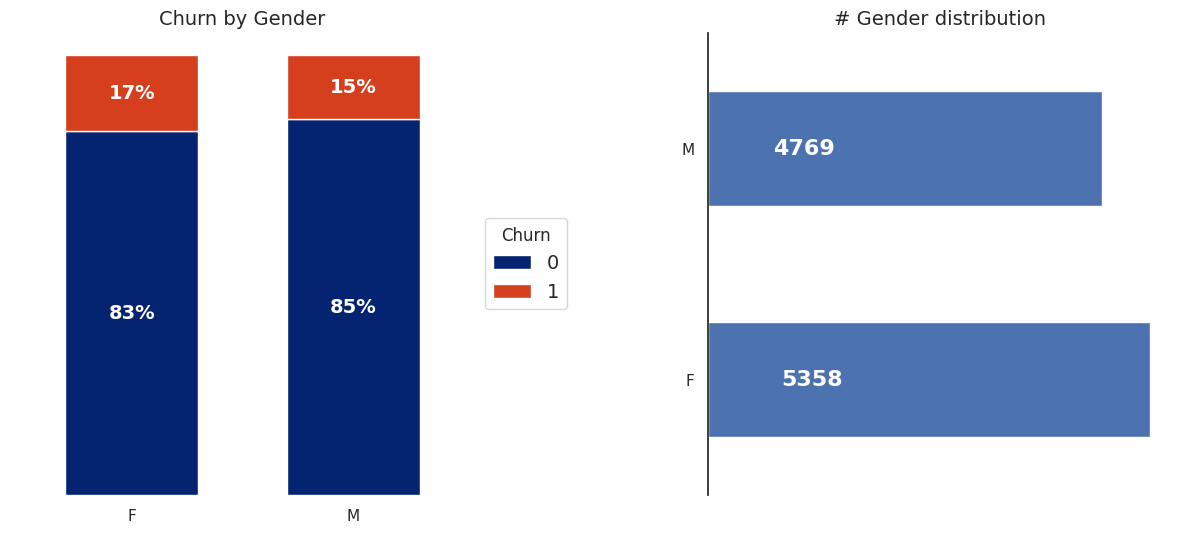

In [23]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(15)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Gender', title= 'Churn by Gender')

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Gender',  title= "# Gender distribution",colors=  ['b'] )

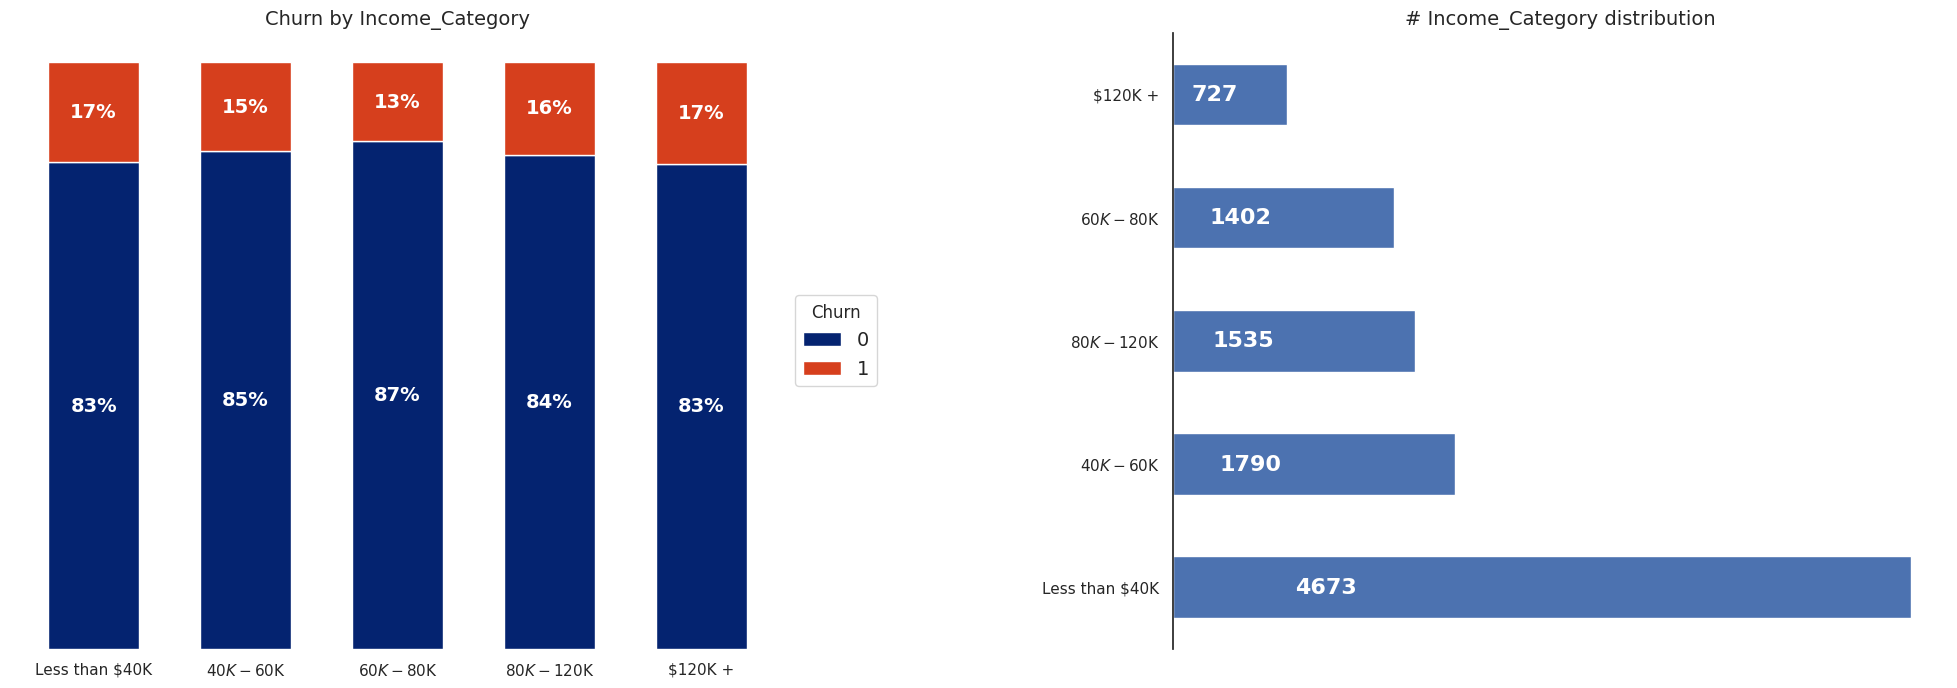

In [24]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(25)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

#reorder the categories
reorderlist =['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Income_Category', title= 'Churn by Income_Category', reorderlist = reorderlist)

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Income_Category',  title= "# Income_Category distribution",colors=  ['b'] )

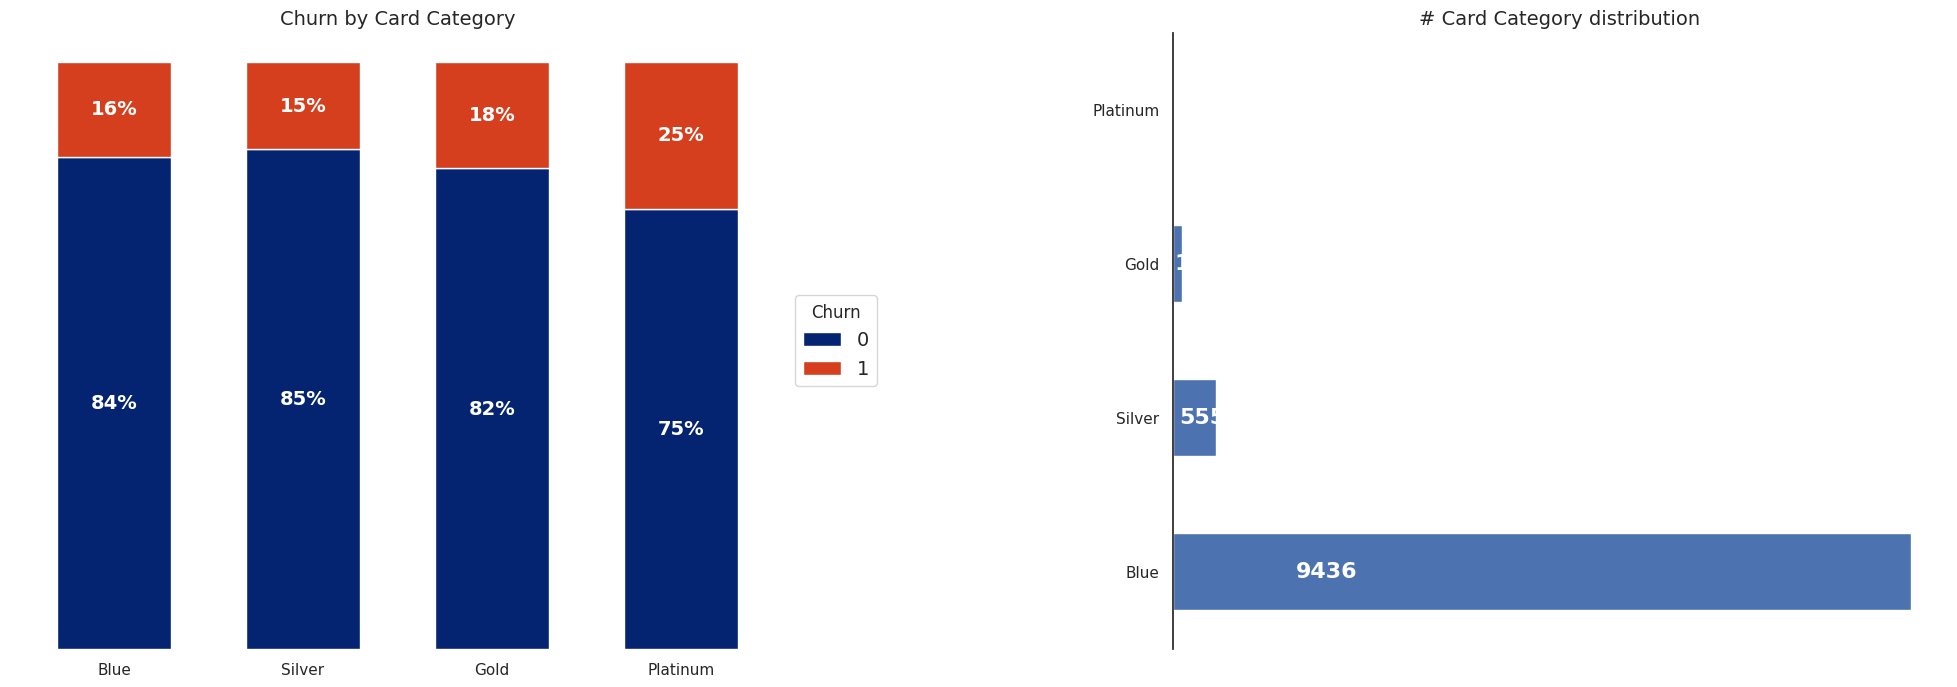

In [25]:
# set figure and size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(25)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

#reorder the categories
reorderlist =['Blue', 'Silver', 'Gold', 'Platinum']

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Card_Category', title= 'Churn by Card Category', reorderlist = reorderlist)

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Card_Category',  title= "# Card Category distribution",colors=  ['b'] )

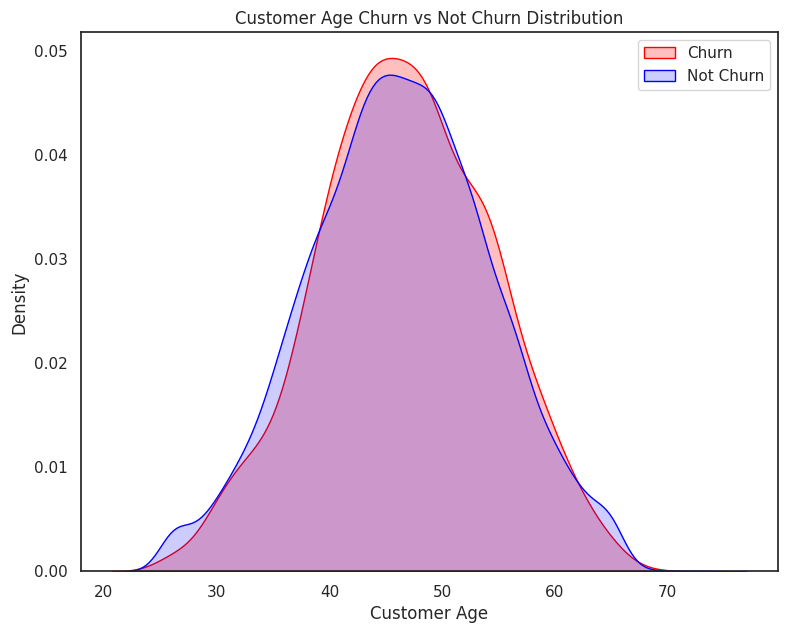

In [26]:
fig, ax = plt.subplots(figsize=(9,7))
dist_plot_kde(df = cust_df,ax = ax,label = 'Churn', feature = "Customer_Age" ,xlabel= 'Customer Age',  title= 'Customer Age Churn vs Not Churn Distribution')

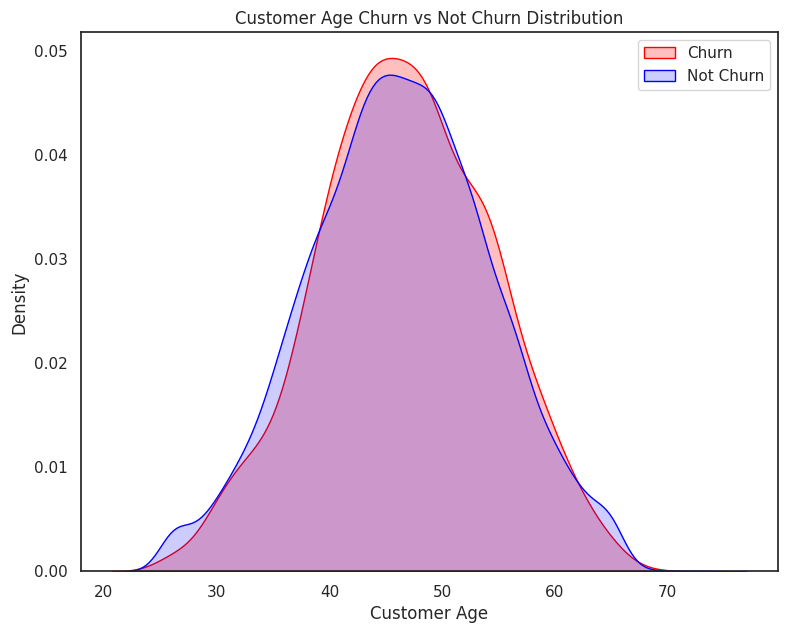

In [27]:
fig, ax = plt.subplots(figsize=(9,7))
dist_plot_kde(df = cust_df,ax = ax,label = 'Churn', feature = "Customer_Age" ,xlabel= 'Customer Age',  title= 'Customer Age Churn vs Not Churn Distribution')

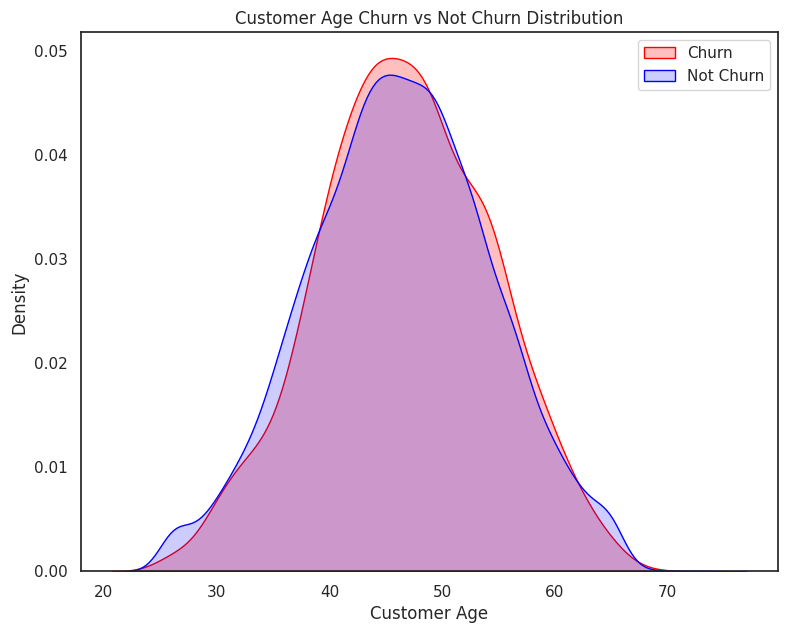

In [28]:
fig, ax = plt.subplots(figsize=(9,7))
dist_plot_kde(df = cust_df,ax = ax,label = 'Churn', feature = "Customer_Age" ,xlabel= 'Customer Age',  title= 'Customer Age Churn vs Not Churn Distribution')

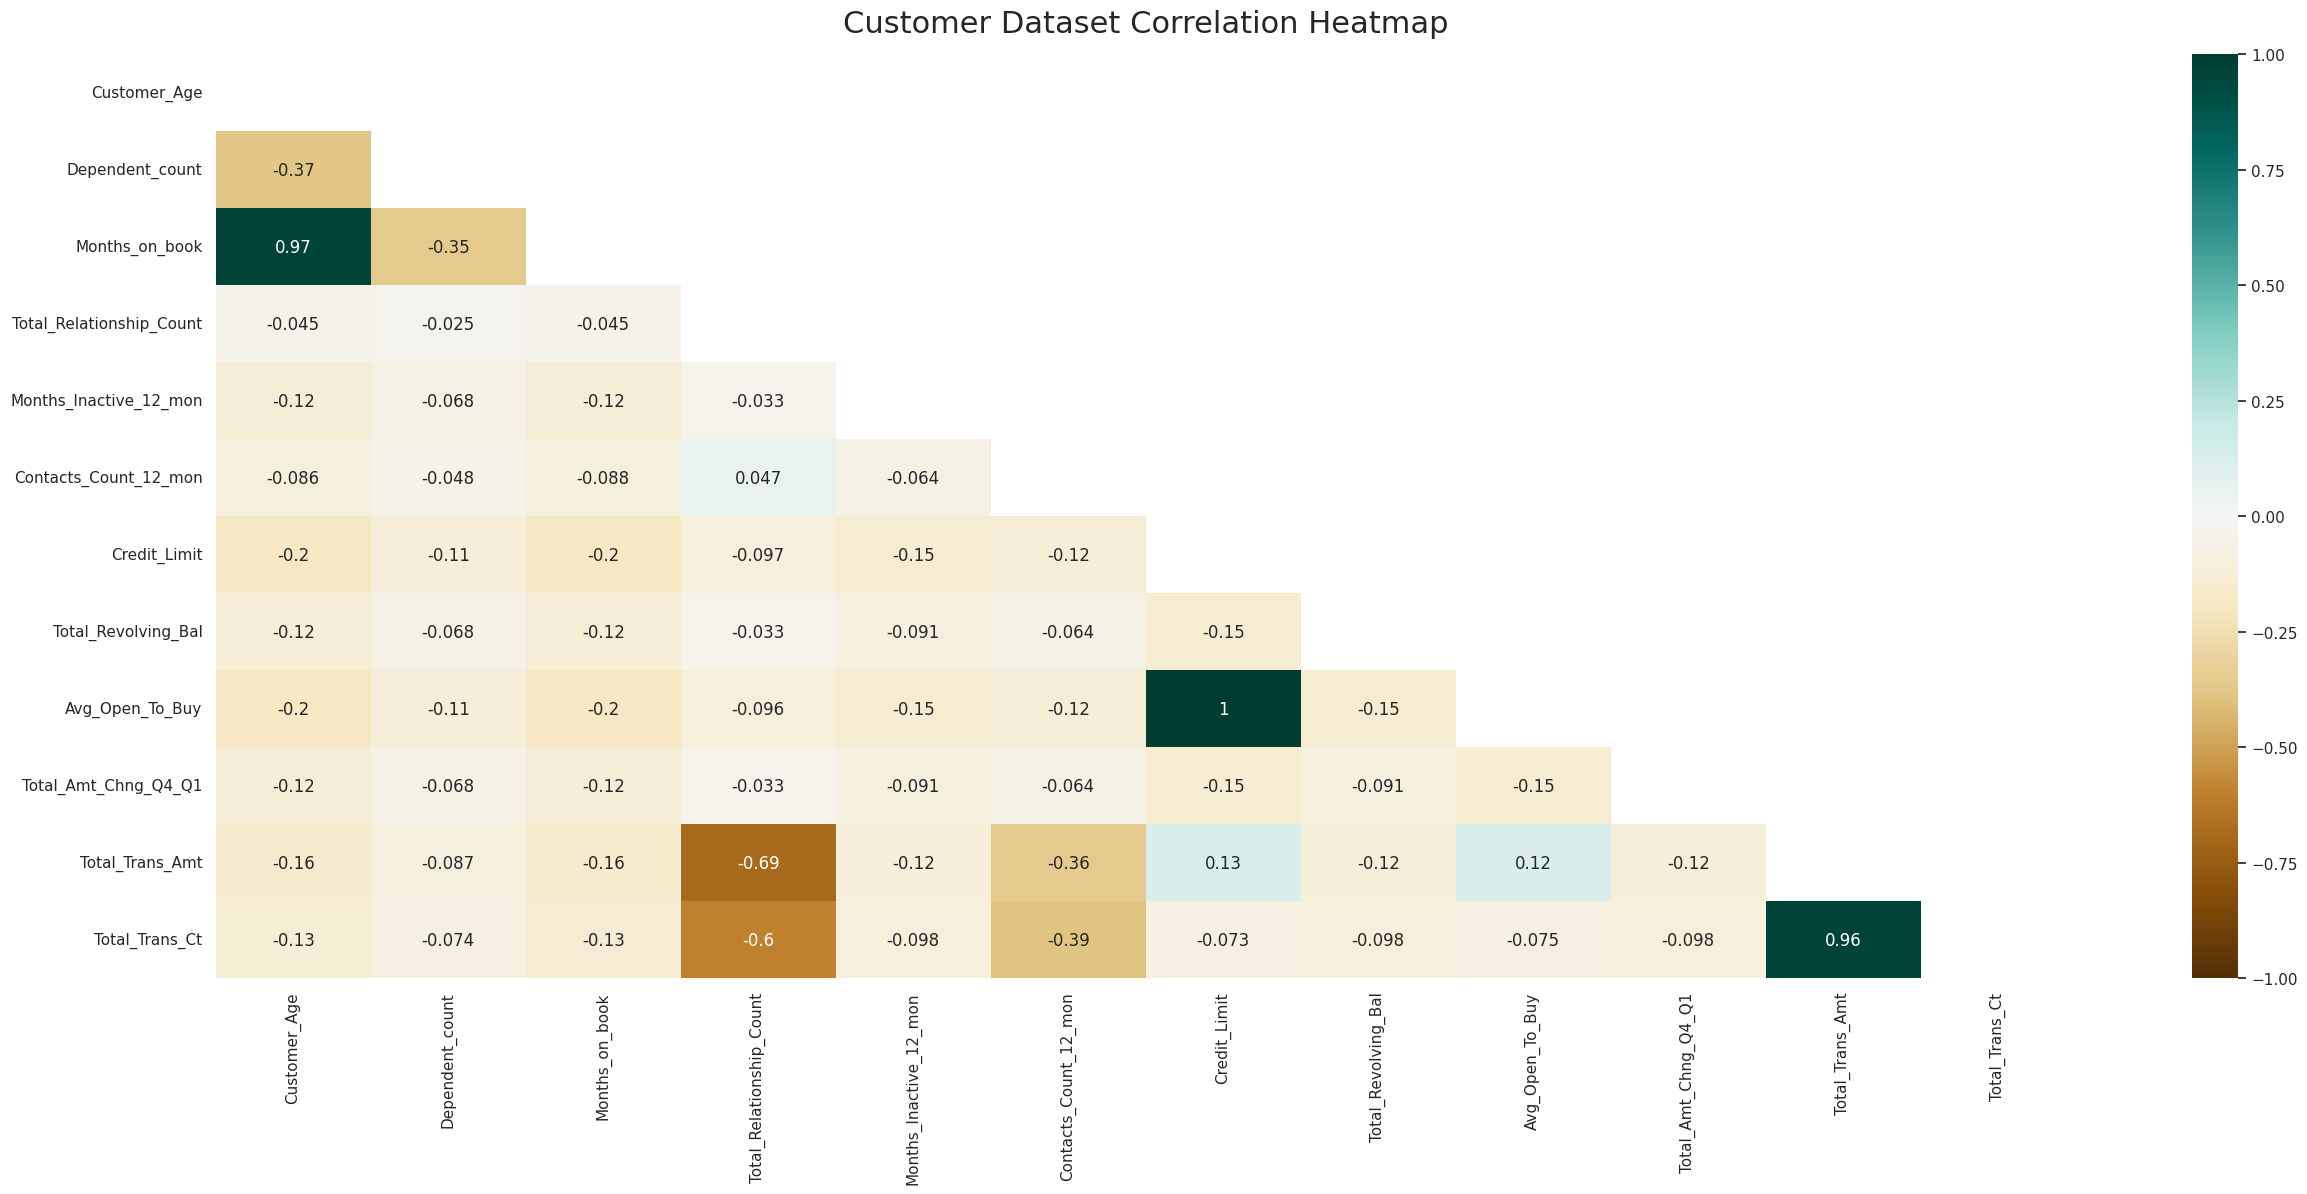

In [29]:
#slect numerical feature and exlude the label
num_data = cust_df.select_dtypes(exclude=['object'])
df_corr_matrix = num_data.iloc[:,:-1].corr()

#if correlation is low put 0 (for correlation matrix redability)
df_corr_matrix[abs(df_corr_matrix) < 0.1] = 0

#plot the correlation matrix
plt.figure(figsize=(30, 12))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_corr_matrix.corr(), dtype=np.bool_))
heatmap = sns.heatmap(df_corr_matrix.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Customer Dataset Correlation Heatmap', fontdict={'fontsize':22}, pad=16);

# Preprocessing and Model selection

## Data Preprocessing

In [30]:
# divide features and label
y = cust_df['Churn'].values
X = cust_df.drop(columns = ['Churn'])

#categorical and numerical
cat_ix = X.select_dtypes(include=['object', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns


# define models
models, names = get_models()
results = list()

#define pipeline for categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

#split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

## Build the Pipeline with SMOTE and Evaluate the Models

In [42]:
# evaluate each models
from numpy import mean, std

#smote for oversampling
smt = SMOTE(random_state=42

for i in range(len(models)):
    # define steps
    steps = [('c',categorical_transformer,cat_ix), ('n',MinMaxScaler(),num_ix)]
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    # wrap the model i a pipeline
    pipeline = imbpipeline(steps=[('t',ct),('smt', smt),('m',models[i])])
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pipeline)
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

# plot the results
plt.figure(figsize=(15, 10))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## Select the best model

### HyperParameters Tuning

In [43]:
# build the parameters grid

param_grid = \
[
    {
    "m__learning_rate":[0.1, 0.5],
    "m__max_depth":[30],
    "m__num_leaves":[10,100],
    "m__feature_fraction":[0.1,1.0],
    "m__subsample":[0.1,1.0],
    }
]
param_grid

[{'m__learning_rate': [0.1, 0.5],
  'm__max_depth': [30],
  'm__num_leaves': [10, 100],
  'm__feature_fraction': [0.1, 1.0],
  'm__subsample': [0.1, 1.0]}]

In [44]:
import warnings
warnings.filterwarnings("ignore")


smt = SMOTE(random_state=42)


CLS = LGBMClassifier()

# define steps
steps = [('c',categorical_transformer,cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps)
# wrap the model i a pipeline
pipeline = imbpipeline(steps=[('t',ct),('smt',smt),('m',CLS)])
# evaluate the model and store results
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                       scoring='recall',
                       return_train_score=True,n_jobs = -1, refit=True)

grid_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 6799, number of negative: 6799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004735 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3684
[LightGBM] [Info] Number of data points in the train set: 13598, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('t',
                                        ColumnTransformer(transformers=[('c',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')),
                                                                        ('n',
                                                                         MinMaxScaler(),
                                                                         Inde...
       'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct'],
      dtype='object'))])),
                                       ('smt', SMOTE(random_state=42)),
                                       ('m', LGBMClassifier())]),
             n_jobs=-1,
             param_grid=[{'m__feature_fraction': [0.1, 1.0],
                          'm__learning_rate': [0.1, 0.5], 'm__max_depth': [30],
                          'm__num_leaves': [10, 100],
                          'm__subsample': [0.1, 1.0]}],
             return_train_score=True, scoring='recall')

In [45]:
import numpy as np
# grid search
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.6820335985853226 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 0.1}
0.6820335985853226 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 1.0}
0.6006483937518421 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 100, 'm__subsample': 0.1}
0.6006483937518421 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 100, 'm__subsample': 1.0}
0.8295343353964043 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.5, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 0.1}
0.8295343353964043 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.5, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 1.0}
0.731243737105806 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.5, 'm__max_depth': 30, 'm__num_leaves': 100, 'm__subsample': 0.1}
0.731243737105806 {'m__feature_fraction': 0.1, 'm__le

In [46]:
print(grid_search.best_score_)
grid_search.best_params_

0.8986383731211317


{'m__feature_fraction': 1.0,
 'm__learning_rate': 0.5,
 'm__max_depth': 30,
 'm__num_leaves': 10,
 'm__subsample': 0.1}

### Test tuned model

In [47]:
name = "LGBMClassifier"
smt = SMOTE(random_state=42)


CLS = LGBMClassifier(feature_fraction = 1.0,learning_rate=0.5,
                     max_depth= 30,num_leaves= 10,subsample= 0.1)

# define steps
steps = [('c',categorical_transformer,cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps)
# wrap the model i a pipeline
pipeline = imbpipeline(steps=[('t',ct),('smt',smt),('m',CLS)])
# evaluate the model and store results
pipeline.fit(X_train, y_train)
#predict
preds = pipeline.predict(X_test)
preds

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Number of positive: 6799, number of negative: 6799
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3684
[LightGBM] [Info] Number of data points in the train set: 13598, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0


array([0, 0, 0, ..., 1, 0, 0])

### Evaluation Metrics

In [48]:
#evaluate final model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import lightgbm as ltb
# Print the prediction accuracy
pred_accuracy = metrics.accuracy_score(y_test, preds)
pred_recall = metrics.recall_score (y_test, preds)
pred_precision = metrics.precision_score (y_test, preds)

print('Accuracy: ' f"{pred_accuracy:,.4%}")
print('Recall: ' f"{pred_recall:,.4%}")
print('Precision: ' f"{pred_precision:,.4%}")

confusion_matrix(y_test,preds)

Accuracy: 97.0879%
Recall: 89.5385%
Precision: 92.0886%


array([[1676,   25],
       [  34,  291]])

Text(66.25, 0.5, 'Actual classes')

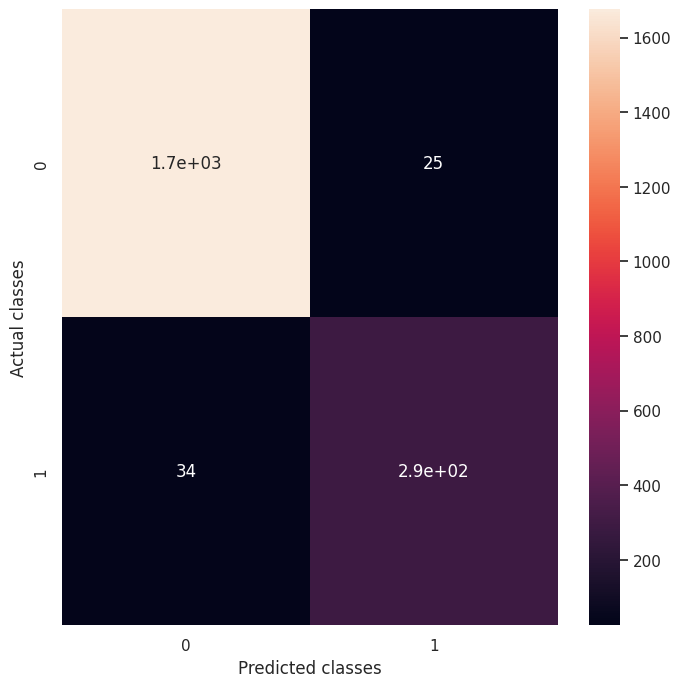

In [49]:
cfm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,8))
sns.heatmap(cfm, annot=True)

plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

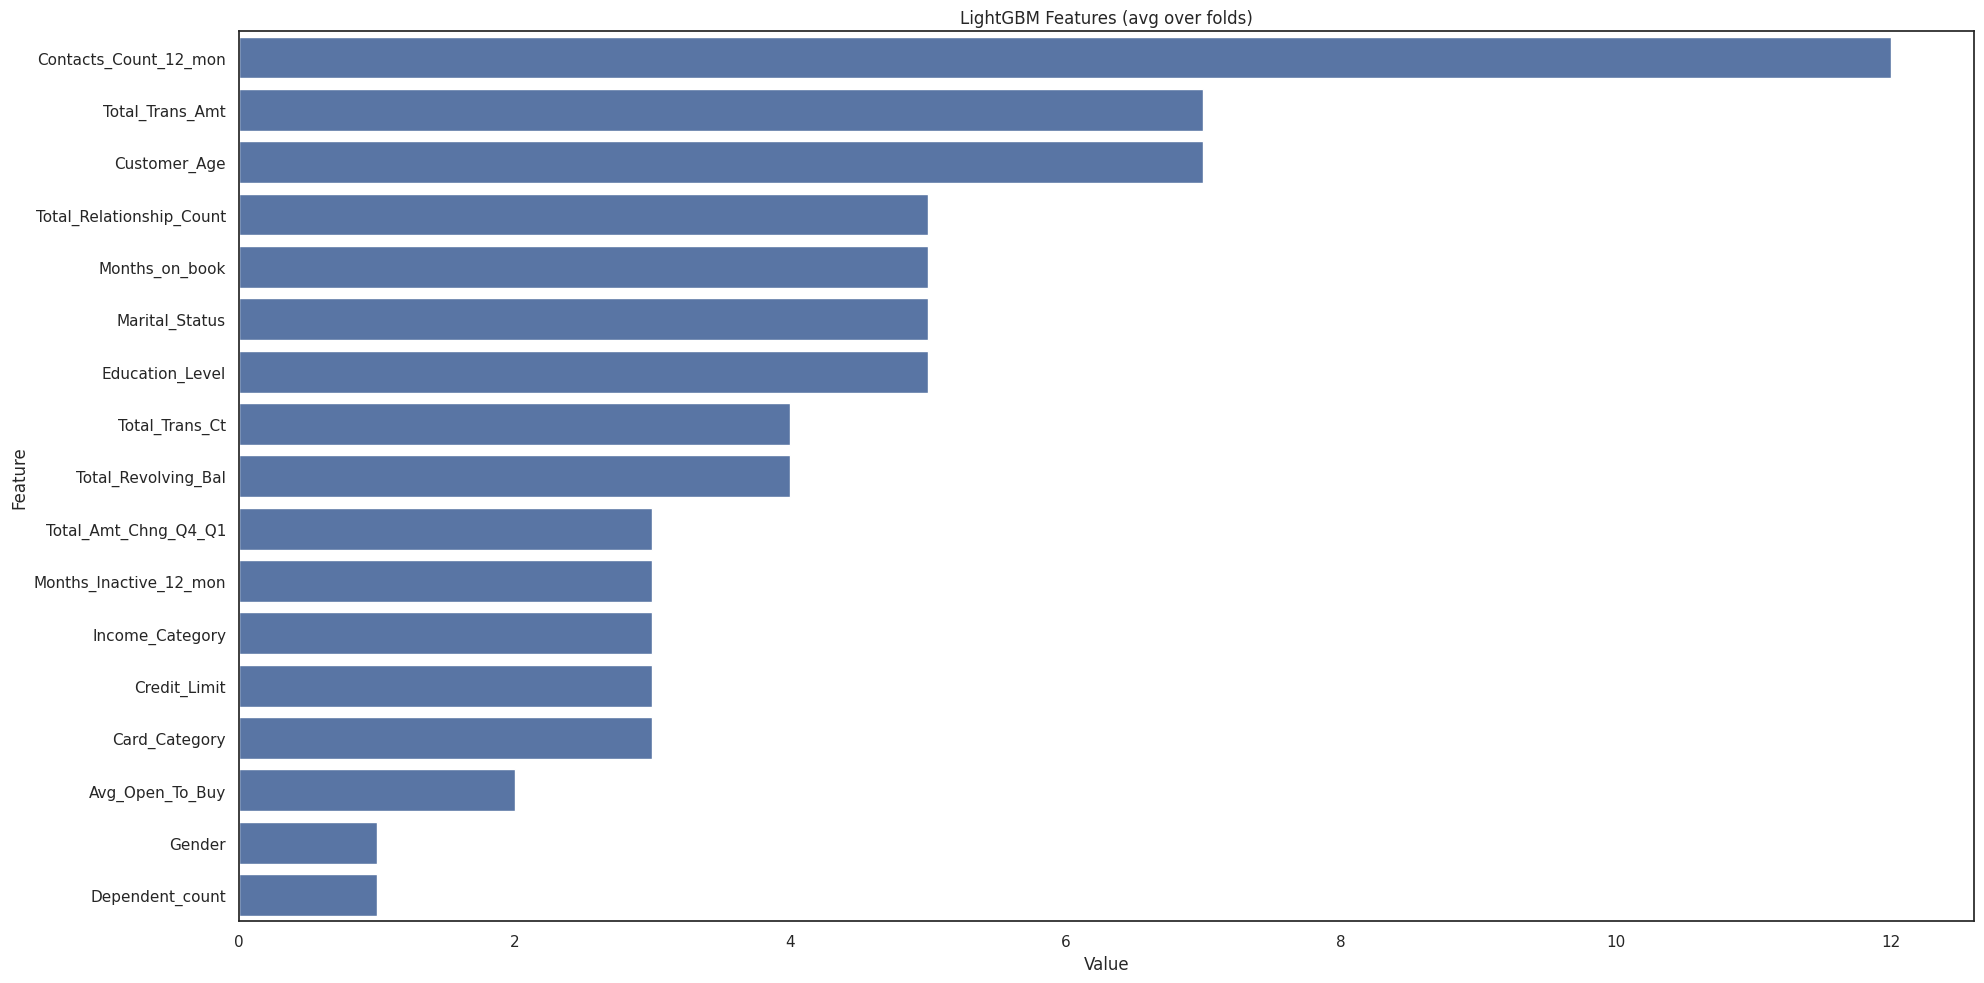

In [50]:
feature_imp = pd.DataFrame(sorted(zip(CLS.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()